In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

user_features = pd.read_parquet("data/processed/user_features.parquet")

y = user_features['churn_30d']

# ID и даты в модель не кормим
X = user_features.drop(columns=['Идентификатор устройства', 'churn_30d', 'first_event', 'last_event'])

# числовые и категориальные признаки
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = ['os', 'device_type', 'manufacturer']

# на всякий случай: если вдруг каких-то колонок нет, отфильтруем
cat_cols = [c for c in cat_cols if c in X.columns]

# пайплайн для числовых признаков: сначала заполняем пропуски, потом масштабируем
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# пайплайн для категориальных: заполняем модой, потом one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

log_reg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg.fit(X_train, y_train)

y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


ROC-AUC: 0.7000384020482664
              precision    recall  f1-score   support

           0       0.71      0.61      0.66     15198
           1       0.60      0.70      0.65     12514

    accuracy                           0.65     27712
   macro avg       0.66      0.66      0.65     27712
weighted avg       0.66      0.65      0.65     27712

[[9297 5901]
 [3742 8772]]


Метрики:
ROC‑AUC: 0.70

Accuracy: 0.65

F1:
класс 0 (активные): 0.66
класс 1 (ушедшие): 0.65

Confusion matrix:
|            | предсказан 0 | предсказан 1 |
| ---------- | -----------: | -----------: |
| **факт 0** |    9297 (TN) |    5901 (FP) |
| **факт 1** |    3742 (FN) |    8772 (TP) |


 * На основе поведенческих признаков пользователей (активность, сессии, использование экранов, устройства) базовая модель логистической регрессии достигает ROC‑AUC ≈ 0.70, что заметно выше случайного угадывания (0.5).

* Модель достаточно сбалансирована: качество по активным и ушедшим пользователям сопоставимо (F1 ≈ 0.65–0.66).

* При текущем пороге 0.5 мы корректно предсказываем около 70% пользователей с оттоком (Recall класса 1 ≈ 0.70), при этом часть активных пользователей ошибочно попадает в “группу риска” (чуть более 5,9 тыс. ложных срабатываний).

* С учётом того, что бизнес не предъявляет жёстких требований к FP/FN, модель уже может использоваться как первый прототип для выделения группы пользователей с повышенной вероятностью оттока.

# 2. Пробуем другие модели на том же пайплайне

## 2.1. Функция для обучения и оценки любой модели

In [4]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

def evaluate_model(pipe, X_train, X_test, y_train, y_test, name="model"):
    pipe.fit(X_train, y_train)
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    
    print(f"=== {name} ===")
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print()


## 2.2. Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        n_jobs=-1,
        random_state=42
    ))
])

evaluate_model(rf_clf, X_train, X_test, y_train, y_test, name="RandomForest")


=== RandomForest ===
ROC-AUC: 0.7064659866776293
              precision    recall  f1-score   support

           0       0.70      0.65      0.67     15198
           1       0.61      0.65      0.63     12514

    accuracy                           0.65     27712
   macro avg       0.65      0.65      0.65     27712
weighted avg       0.66      0.65      0.65     27712

[[9932 5266]
 [4325 8189]]



## 2.3. CatBoost

In [ ]:
import numpy as np
from catboost import CatBoostClassifier

# получаем преобразованные фичи (dense)
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

# если OneHotEncoder вернул sparse, конвертируем
if not isinstance(X_train_proc, np.ndarray):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

cb_clf = CatBoostClassifier(
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=300,
    verbose=False,
    random_seed=42
)

cb_clf.fit(X_train_proc, y_train)
y_pred_proba = cb_clf.predict_proba(X_test_proc)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("=== CatBoost ===")
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

=== CatBoost ===
ROC-AUC: 0.710633638949196
              precision    recall  f1-score   support

           0       0.70      0.65      0.67     15198
           1       0.61      0.66      0.63     12514

    accuracy                           0.65     27712
   macro avg       0.65      0.65      0.65     27712
weighted avg       0.66      0.65      0.65     27712

[[9878 5320]
 [4281 8233]]


# Тюнинг

## 3.1 Лёгкий тюнинг CatBoost (RandomizedSearch)

In [7]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np

# если вдруг матрица не numpy
if not isinstance(X_train_proc, np.ndarray):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

cb_base = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42
)

param_dist = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'iterations': [200, 400, 800],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 1, 3]
}

rs_cb = RandomizedSearchCV(
    estimator=cb_base,
    param_distributions=param_dist,
    n_iter=12,              # немного, чтобы не убиться по времени
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs_cb.fit(X_train_proc, y_train)

print("Лучшие параметры:", rs_cb.best_params_)
print("CV ROC-AUC:", rs_cb.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшие параметры: {'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 800, 'depth': 6, 'bagging_temperature': 0}
CV ROC-AUC: 0.7092510819930506


In [8]:
cb_best = rs_cb.best_estimator_

y_pred_proba = cb_best.predict_proba(X_test_proc)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("=== CatBoost tuned ===")
print("Test ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


=== CatBoost tuned ===
Test ROC-AUC: 0.7105661871889428
              precision    recall  f1-score   support

           0       0.70      0.65      0.67     15198
           1       0.61      0.66      0.63     12514

    accuracy                           0.65     27712
   macro avg       0.65      0.65      0.65     27712
weighted avg       0.66      0.65      0.65     27712

[[9914 5284]
 [4308 8206]]


## 3.2. Тюнинг порога


Сейчас порог = 0.5. Попробуем подобрать его под задачу: например, поднять Recall по churn‑классу (1) при умеренном падении Precision/Accuracy

In [9]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_test, y_pred_proba)

# пример: ищем порог с Recall >= 0.8
target_recall = 0.8
best_idx = np.argmax(rec >= target_recall)

best_threshold = thresholds[best_idx]
print("Порог для recall>=0.8:", best_threshold)
print("recall:", rec[best_idx], "precision:", prec[best_idx])


Порог для recall>=0.8: 0.00785008733570917
recall: 1.0 precision: 0.45157332563510394


In [10]:
y_pred_thr = (y_pred_proba >= best_threshold).astype(int)

print("=== CatBoost tuned threshold ===")
print(classification_report(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))


=== CatBoost tuned threshold ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15198
           1       0.45      1.00      0.62     12514

    accuracy                           0.45     27712
   macro avg       0.23      0.50      0.31     27712
weighted avg       0.20      0.45      0.28     27712

[[    0 15198]
 [    0 12514]]


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

При стандартном пороге 0.5 модель CatBoost показывает сбалансированное качество по обоим классам (Recall ≈ 0.65–0.66). Попытка радикально поднять Recall за счёт сильного снижения порога приводит к тому, что модель начинает относить почти всех пользователей к “группе риска” (Recall → 1.0, но Accuracy падает до ~0.45, весь класс 0 предсказывается как отток). Поэтому на следующем шаге имеет смысл подбирать порог не только по Recall, но и с учётом Precision / F1.

# Дополнительный анализ, с добавлением фичи индекса кластера поведения пользователя.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

user_features = pd.read_parquet("data/processed/user_features_with_clusters.parquet")

y = user_features['churn_30d']

# В модель не передаём ID и даты
drop_cols = ['Идентификатор устройства', 'churn_30d', 'first_event', 'last_event']
drop_cols = [c for c in drop_cols if c in user_features.columns]

X = user_features.drop(columns=drop_cols).copy()

# Сделаем кластер категориальным, если он есть
if 'cluster_kmeans' in X.columns:
    X['cluster_kmeans'] = X['cluster_kmeans'].astype('category')

# Числовые и категориальные признаки автоматически
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)


Numeric: ['events_total', 'sessions_total', 'unique_screens', 'unique_functional', 'active_days', 'events_per_day', 'sessions_per_day', 'screen_Важное', 'screen_Еще', 'screen_Мои баллы', 'screen_Новая заявка', 'screen_Новое ОСС', 'screen_Объявления', 'screen_Связаться с владельцем ТС', 'screen_Услуги', 'cluster_dbscan']
Categorical: ['os', 'device_type', 'manufacturer', 'cluster_kmeans']


In [2]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

log_reg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg.fit(X_train, y_train)

y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

print("=== Logistic regression + clusters ===")
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


=== Logistic regression + clusters ===
ROC-AUC: 0.7012269747815334
              precision    recall  f1-score   support

           0       0.71      0.62      0.66     15198
           1       0.60      0.69      0.64     12514

    accuracy                           0.65     27712
   macro avg       0.65      0.65      0.65     27712
weighted avg       0.66      0.65      0.65     27712

[[9442 5756]
 [3911 8603]]


In [3]:
# Преобразуем фичи через preprocess, как раньше
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

# если матрица разреженная, переводим в плотный формат
if not isinstance(X_train_proc, np.ndarray):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier(
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=300,
    verbose=False,
    random_seed=42
)

cb_clf.fit(X_train_proc, y_train)

y_pred_proba_cb = cb_clf.predict_proba(X_test_proc)[:, 1]
y_pred_cb = (y_pred_proba_cb >= 0.5).astype(int)

print("=== CatBoost + clusters ===")
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_cb))
print(classification_report(y_test, y_pred_cb))
print(confusion_matrix(y_test, y_pred_cb))


=== CatBoost + clusters ===
ROC-AUC: 0.7104216326799391
              precision    recall  f1-score   support

           0       0.70      0.65      0.67     15198
           1       0.61      0.66      0.63     12514

    accuracy                           0.65     27712
   macro avg       0.65      0.65      0.65     27712
weighted avg       0.66      0.65      0.65     27712

[[9864 5334]
 [4287 8227]]


# Исключение опреленных пользователей (кластера) из обучения модели оттока

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)

df = pd.read_parquet("data/processed/user_features_with_clusters.parquet").copy()

# 0.1. "одноразовые"
df["is_one_time"] = (
    (df["events_total"] <= 3) &
    (df["sessions_total"] <= 1) &
    (df["active_days"] <= 1)
).astype(int)

one_time_stats = df.groupby("is_one_time")["churn_30d"].agg(
    users="count", churn_rate="mean"
)
one_time_stats["churn_rate"] = one_time_stats["churn_rate"] * 100
one_time_stats


,users,churn_rate
is_one_time,,
0,113885,41.246872
1,24674,63.200130


In [10]:
pd.crosstab(
    df["cluster_kmeans"].astype(str),
    df["is_one_time"],
    normalize="index"
) * 100

is_one_time,0,1
cluster_kmeans,,
0,48.504816,51.495184
1,96.598331,3.401669
2,100.000000,0.000000
3,67.648957,32.351043
4,100.000000,0.000000
5,99.870968,0.129032
6,98.089545,1.910455


# Функции: метрики по кластерам + выбор “самого проблемного”

In [ ]:
def auc_safe(y_true, y_proba):
    # AUC не считается, если в сегменте только один класс
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_proba)

def per_segment_metrics(df_pred, seg_col="cluster_kmeans", thr=0.5):
    """
    df_pred: колонки y_true, y_proba + seg_col
    """
    rows = []
    for seg, g in df_pred.groupby(seg_col):
        y_true = g["y_true"].values
        y_proba = g["y_proba"].values
        y_pred = (y_proba >= thr).astype(int)

        rows.append({
            seg_col: seg,
            "n": len(g),
            "churn_rate_%": 100 * y_true.mean(),
            "auc": auc_safe(y_true, y_proba),
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "error_rate": (y_pred != y_true).mean()
        })

    out = pd.DataFrame(rows).sort_values("error_rate", ascending=False)
    return out


## Делим train/val/test

In [11]:
from sklearn.model_selection import train_test_split

# y и X как раньше
y = df["churn_30d"].astype(int)

drop_cols = ["Идентификатор устройства", "churn_30d", "first_event", "last_event"]
drop_cols = [c for c in drop_cols if c in df.columns]
X = df.drop(columns=drop_cols).copy()

# категориальные
for c in ["os", "device_type", "manufacturer", "cluster_kmeans"]:
    if c in X.columns:
        X[c] = X[c].astype("category")

# НЕ используем cluster_dbscan как число
if "cluster_dbscan" in X.columns:
    X = X.drop(columns=["cluster_dbscan"])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(len(X_train), len(X_val), len(X_test))


83135 27712 27712


## Обучаем модель и считаем ошибки по кластерам на VAL

In [12]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) in ["category", "object"]]

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
val_pool = Pool(X_val, y_val, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

cb = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=200,
    od_type="Iter",
    od_wait=100
)

cb.fit(train_pool, eval_set=val_pool, use_best_model=True)

val_proba = cb.predict_proba(val_pool)[:, 1]
test_proba = cb.predict_proba(test_pool)[:, 1]

print("VAL AUC:", roc_auc_score(y_val, val_proba))
print("TEST AUC:", roc_auc_score(y_test, test_proba))


0:	test: 0.6913406	best: 0.6913406 (0)	total: 124ms	remaining: 4m 8s
200:	test: 0.7089550	best: 0.7090113 (195)	total: 22.6s	remaining: 3m 22s
400:	test: 0.7100562	best: 0.7101705 (372)	total: 48.4s	remaining: 3m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7101705492
bestIteration = 372

Shrink model to first 373 iterations.
VAL AUC: 0.7101705492401478
TEST AUC: 0.7099987506031671


In [13]:
val_pred_df = pd.DataFrame({
    "y_true": y_val.values,
    "y_proba": val_proba,
    "cluster_kmeans": X_val["cluster_kmeans"].astype(str).values
})

seg_val = per_segment_metrics(val_pred_df, seg_col="cluster_kmeans", thr=0.5)
seg_val

,cluster_kmeans,n,churn_rate_%,auc,accuracy,precision,recall,f1,error_rate
1,1,2255,51.086475,0.591714,0.572506,0.575080,0.625000,0.599002,0.427494
3,3,2822,57.335223,0.559756,0.593551,0.598494,0.884425,0.713894,0.406449
0,0,7418,59.989215,0.575571,0.610272,0.611724,0.959101,0.747003,0.389728
6,6,3407,58.878779,0.609797,0.620781,0.634009,0.841974,0.723340,0.379219
5,5,295,46.779661,0.699160,0.661017,0.635714,0.644928,0.640288,0.338983
4,4,7610,30.420499,0.679308,0.693955,0.447761,0.025918,0.049000,0.306045
2,2,3905,21.382843,0.704921,0.785147,0.409091,0.010778,0.021004,0.214853


1. Кластеры 0 / 3 / 6 — “высокий churn” и высокий recall

* churn_rate ≈ 58–60%

* recall высокий (0.84–0.96) → модель почти всех относит к churn

* AUC низкий (~0.56–0.61) → внутри этих сегментов модель плохо ранжирует, то есть не умеет различать “уйдёт/не уйдёт” среди похожих пользователей

Интерпретация: эти кластеры — “краткоживущие/одноразовые/интенсивные короткие сценарии”. Они похожи по агрегатам, а churn определяется “исчез/не исчез” → внутри сегмента сигнал слабый.

2. Кластеры 2 и 4 — “низкий churn”, высокая accuracy, но почти нулевая recall

* churn_rate ≈ 21% (кластер 2) и 30% (кластер 4)

* accuracy высокая (0.78 и 0.69)

* recall почти ноль (~0.01–0.03) → модель почти никого не помечает как churn при пороге 0.5

* AUC при этом нормальный (~0.68–0.70) → ранжирование в целом неплохое, проблема в пороге

Интерпретация: здесь у модели есть сигнал, но универсальный порог 0.5 не подходит. Это шикарный повод сделать “порог по сегментам” (это будет очень круто выглядеть).

3. Кластер 1 — “самый проблемный”

* самая высокая error_rate ≈ 0.43

* AUC ≈ 0.59 — слабовато

* churn_rate ≈ 51%

Интерпретация: сегмент “средний по churn”, но модель не может стабильно отличать.

4. Кластер 5 — маленький (n=295)

* метрики нестабильны из-за малого размера; выводы осторожно.

“самый плохой по error_rate” ≠ “самый вредный для итоговой метрики”

In [14]:
bad_cluster = seg_val.iloc[0]["cluster_kmeans"]
bad_cluster

'1'

# Эксперимент: исключаем bad_cluster, переобучаем, сравниваем на TEST (без этого кластера)

In [15]:
mask_train_ok = X_train["cluster_kmeans"].astype(str) != str(bad_cluster)
mask_val_ok = X_val["cluster_kmeans"].astype(str) != str(bad_cluster)
mask_test_ok = X_test["cluster_kmeans"].astype(str) != str(bad_cluster)

X_train2, y_train2 = X_train[mask_train_ok], y_train[mask_train_ok]
X_val2, y_val2 = X_val[mask_val_ok], y_val[mask_val_ok]
X_test2, y_test2 = X_test[mask_test_ok], y_test[mask_test_ok]

train2_pool = Pool(X_train2, y_train2, cat_features=cat_cols)
val2_pool = Pool(X_val2, y_val2, cat_features=cat_cols)
test2_pool = Pool(X_test2, y_test2, cat_features=cat_cols)

cb2 = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=200,
    od_type="Iter",
    od_wait=100
)

cb2.fit(train2_pool, eval_set=val2_pool, use_best_model=True)

test2_proba = cb2.predict_proba(test2_pool)[:, 1]

print("TEST AUC (без bad_cluster):", roc_auc_score(y_test2, test2_proba))
print("Coverage on TEST:", len(y_test2), "/", len(y_test), "=", len(y_test2)/len(y_test))

0:	test: 0.6952434	best: 0.6952434 (0)	total: 134ms	remaining: 4m 28s
200:	test: 0.7164753	best: 0.7165092 (199)	total: 20.6s	remaining: 3m 4s
400:	test: 0.7169986	best: 0.7173604 (300)	total: 41.8s	remaining: 2m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7173604234
bestIteration = 300

Shrink model to first 301 iterations.
TEST AUC (без bad_cluster): 0.7161838851766795
Coverage on TEST: 25577 / 27712 = 0.9229575635103926


# routing / разные пороги по кластерам.

## Базовая оценка при пороге 0.5

In [16]:
def eval_at_threshold(y_true, y_proba, thr=0.5, title=""):
    y_pred = (y_proba >= thr).astype(int)
    print(f"\n=== {title} threshold={thr:.3f} ===")
    print("accuracy:", accuracy_score(y_true, y_pred))
    print("precision:", precision_score(y_true, y_pred, zero_division=0))
    print("recall:", recall_score(y_true, y_pred, zero_division=0))
    print("f1:", f1_score(y_true, y_pred, zero_division=0))
    print("confusion_matrix:\n", confusion_matrix(y_true, y_pred))
    return y_pred

# baseline
base_val_pred = eval_at_threshold(y_val.values, val_proba, thr=0.5, title="VAL baseline")
base_test_pred = eval_at_threshold(y_test.values, test_proba, thr=0.5, title="TEST baseline")


=== VAL baseline threshold=0.500 ===
accuracy: 0.6549509237875288
precision: 0.6086892488954344
recall: 0.6605401949816205
f1: 0.6335556066528704
confusion_matrix:
 [[9884 5314]
 [4248 8266]]

=== TEST baseline threshold=0.500 ===
accuracy: 0.6535435912240185
precision: 0.6074987083917632
recall: 0.6577433274732299
f1: 0.6316233741319112
confusion_matrix:
 [[9880 5318]
 [4283 8231]]


## Подбор порога на валидации (по F1) — глобально и по кластерам

### Функция подбора порога по F1

In [35]:
def best_threshold_by_f1(y_true, y_proba, grid=None, min_pos_rate=0.05, max_pos_rate=0.80):
    """
    Ищем порог, максимизирующий F1 по классу churn=1.
    min_pos_rate/max_pos_rate ограничивают деградацию (не хотим предсказывать почти всех в churn).
    """
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)

    best = {"thr": 0.5, "f1": -1, "precision": None, "recall": None, "pos_rate": None}

    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    # если в сегменте только один класс — F1 бессмысленно оптимизировать
    if len(np.unique(y_true)) < 2:
        return best

    for thr in grid:
        y_pred = (y_proba >= thr).astype(int)
        pos_rate = y_pred.mean()

        if pos_rate < min_pos_rate or pos_rate > max_pos_rate:
            continue

        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1), "precision": float(prec), "recall": float(rec), "pos_rate": float(pos_rate)}

    return best


### Глобальный лучший порог (на всей валидации)

In [36]:
best_global = best_threshold_by_f1(y_val.values, val_proba)

In [37]:
_ = eval_at_threshold(y_val.values, val_proba, thr=best_global["thr"], title="VAL best-global-F1")
_ = eval_at_threshold(y_test.values, test_proba, thr=best_global["thr"], title="TEST best-global-F1")



=== VAL best-global-F1 threshold=0.370 ===
accuracy: 0.6319644919168591
precision: 0.5603839532578643
recall: 0.8583985935751958
f1: 0.6780923523656219
confusion_matrix:
 [[ 6771  8427]
 [ 1772 10742]]

=== TEST best-global-F1 threshold=0.370 ===
accuracy: 0.6288972286374134
precision: 0.5579461594428854
recall: 0.8579191305737573
f1: 0.6761556871142461
confusion_matrix:
 [[ 6692  8506]
 [ 1778 10736]]


## Сегментные пороги по cluster_kmeans (подбор на VAL)

In [38]:
val_df = pd.DataFrame({
    "y_true": y_val.values,
    "y_proba": val_proba,
    "cluster": X_val["cluster_kmeans"].astype(str).values
})

test_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_proba": test_proba,
    "cluster": X_test["cluster_kmeans"].astype(str).values
})

thresholds = {}
rows = []

# правило: если сегмент маленький — используем global threshold
MIN_SEGMENT_SIZE = 500

for cl, g in val_df.groupby("cluster"):
    if len(g) < MIN_SEGMENT_SIZE:
        thr_info = {"thr": best_global["thr"], "f1": np.nan, "precision": np.nan, "recall": np.nan, "pos_rate": np.nan}
        reason = "fallback_small_segment"
    else:
        thr_info = best_threshold_by_f1(g["y_true"].values, g["y_proba"].values)
        # если не нашли адекватный порог — fallback
        if thr_info["f1"] == -1:
            thr_info = {"thr": best_global["thr"], "f1": np.nan, "precision": np.nan, "recall": np.nan, "pos_rate": np.nan}
            reason = "fallback_no_valid_thr"
        else:
            reason = "cluster_f1"

    thresholds[cl] = thr_info["thr"]

    rows.append({
        "cluster": cl,
        "n_val": len(g),
        "churn_rate_val_%": 100 * g["y_true"].mean(),
        "thr": thr_info["thr"],
        "f1_val": thr_info.get("f1", np.nan),
        "precision_val": thr_info.get("precision", np.nan),
        "recall_val": thr_info.get("recall", np.nan),
        "pos_rate_pred_val": thr_info.get("pos_rate", np.nan),
        "how": reason
    })

thr_table = pd.DataFrame(rows).sort_values("cluster")
thr_table


,cluster,n_val,churn_rate_val_%,thr,f1_val,precision_val,recall_val,pos_rate_pred_val,how
0,0,7418,59.989215,0.55,0.717233,0.630342,0.831910,0.791723,cluster_f1
1,1,2255,51.086475,0.43,0.653846,0.540909,0.826389,0.780488,cluster_f1
2,2,3905,21.382843,0.28,0.441428,0.380416,0.525749,0.295519,cluster_f1
3,3,2822,57.335223,0.57,0.702535,0.604093,0.839308,0.796598,cluster_f1
4,4,7610,30.420499,0.27,0.527153,0.389439,0.815551,0.637057,cluster_f1
5,5,295,46.779661,0.37,NaN,NaN,NaN,NaN,fallback_small_segment
6,6,3407,58.878779,0.50,0.723340,0.634009,0.841974,0.781920,cluster_f1


In [39]:
thr_table.to_csv("reports/segment_thresholds_by_cluster.csv", index=False)

## Применяем сегментные пороги на TEST и сравниваем с baseline

In [40]:
def apply_segment_thresholds(df_pred, thr_map, default_thr=0.5):
    thr_used = df_pred["cluster"].map(thr_map).fillna(default_thr).values
    y_pred = (df_pred["y_proba"].values >= thr_used).astype(int)
    return y_pred, thr_used

test_pred_seg, thr_used_test = apply_segment_thresholds(test_df, thresholds, default_thr=best_global["thr"])

print("\n=== TEST segment thresholds ===")
print("accuracy:", accuracy_score(test_df["y_true"], test_pred_seg))
print("precision:", precision_score(test_df["y_true"], test_pred_seg, zero_division=0))
print("recall:", recall_score(test_df["y_true"], test_pred_seg, zero_division=0))
print("f1:", f1_score(test_df["y_true"], test_pred_seg, zero_division=0))
print("confusion_matrix:\n", confusion_matrix(test_df["y_true"], test_pred_seg))



=== TEST segment thresholds ===
accuracy: 0.5971420323325635
precision: 0.5361542581681843
recall: 0.7999041073997123
f1: 0.6419958953309389
confusion_matrix:
 [[ 6538  8660]
 [ 2504 10010]]


In [41]:
def metrics_row(y_true, y_pred, name):
    return {
        "variant": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

y_test_true = test_df["y_true"].values
pred_05 = (test_df["y_proba"].values >= 0.5).astype(int)
pred_glob = (test_df["y_proba"].values >= best_global["thr"]).astype(int)

compare = pd.DataFrame([
    metrics_row(y_test_true, pred_05, "global_thr_0.5"),
    metrics_row(y_test_true, pred_glob, f"global_thr_bestF1={best_global['thr']:.3f}"),
    metrics_row(y_test_true, test_pred_seg, "segment_thresholds_by_cluster"),
])

compare


,variant,accuracy,precision,recall,f1
0,global_thr_0.5,0.653544,0.607499,0.657743,0.631623
1,global_thr_bestF1=0.370,0.628897,0.557946,0.857919,0.676156
2,segment_thresholds_by_cluster,0.597142,0.536154,0.799904,0.641996


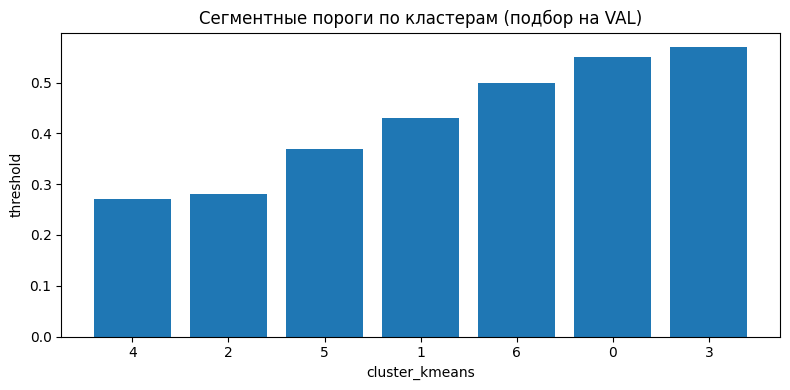

In [42]:
import matplotlib.pyplot as plt
plot_df = thr_table.sort_values("thr")

plt.figure(figsize=(8, 4))
plt.bar(plot_df["cluster"], plot_df["thr"])
plt.title("Сегментные пороги по кластерам (подбор на VAL)")
plt.xlabel("cluster_kmeans")
plt.ylabel("threshold")
plt.tight_layout()
plt.show()


## пороги по (кластер + one_time)

In [43]:
val_df = pd.DataFrame({
    "y_true": y_val.values,
    "y_proba": val_proba,
    "cluster": X_val["cluster_kmeans"].astype(str).values,
    "is_one_time": X_val["is_one_time"].values
})
val_df["segment"] = val_df["cluster"] + "_ot" + val_df["is_one_time"].astype(str)

test_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_proba": test_proba,
    "cluster": X_test["cluster_kmeans"].astype(str).values,
    "is_one_time": X_test["is_one_time"].values
})
test_df["segment"] = test_df["cluster"] + "_ot" + test_df["is_one_time"].astype(str)

val_df.head(), test_df.head()

(   y_true   y_proba cluster  is_one_time segment
 0       1  0.403368       4            0   4_ot0
 1       1  0.640545       3            0   3_ot0
 2       0  0.230421       4            0   4_ot0
 3       1  0.176495       4            0   4_ot0
 4       0  0.150444       2            0   2_ot0,
    y_true   y_proba cluster  is_one_time segment
 0       0  0.292705       4            0   4_ot0
 1       0  0.074232       4            0   4_ot0
 2       0  0.297067       2            0   2_ot0
 3       1  0.277809       2            0   2_ot0
 4       1  0.625128       0            0   0_ot0)

### Подбираем пороги по сегментам (segment = cluster+one_time) на VAL

In [44]:
MIN_SEGMENT_SIZE_SEG = 300  # для cluster+one_time сегменты меньше, чем по кластерам

segment_thresholds = {}
rows = []

for seg, g in val_df.groupby("segment"):
    cluster = g["cluster"].iloc[0]

    # fallback: сначала порог кластера, иначе глобальный
    fallback_thr = thresholds.get(cluster, best_global["thr"])

    if len(g) < MIN_SEGMENT_SIZE_SEG or len(np.unique(g["y_true"])) < 2:
        thr = fallback_thr
        how = "fallback_small_or_oneclass"
        f1v = np.nan
        precv = np.nan
        recv = np.nan
        posrate = np.nan
    else:
        best = best_threshold_by_f1(g["y_true"].values, g["y_proba"].values)
        if best["f1"] == -1:
            thr = fallback_thr
            how = "fallback_no_valid_thr"
            f1v = np.nan
            precv = np.nan
            recv = np.nan
            posrate = np.nan
        else:
            thr = best["thr"]
            how = "segment_f1"
            f1v = best["f1"]
            precv = best["precision"]
            recv = best["recall"]
            posrate = best["pos_rate"]

    segment_thresholds[seg] = thr

    rows.append({
        "segment": seg,
        "cluster": cluster,
        "is_one_time": int(g["is_one_time"].iloc[0]),
        "n_val": len(g),
        "churn_rate_val_%": 100 * g["y_true"].mean(),
        "thr": thr,
        "f1_val": f1v,
        "precision_val": precv,
        "recall_val": recv,
        "pos_rate_pred_val": posrate,
        "how": how
    })

thr_table_seg = pd.DataFrame(rows).sort_values(["cluster", "is_one_time"])
thr_table_seg


,segment,cluster,is_one_time,n_val,churn_rate_val_%,thr,f1_val,precision_val,recall_val,pos_rate_pred_val,how
0,0_ot0,0,0,3586,55.772448,0.53,0.666522,0.589615,0.766500,0.725042,segment_f1
1,0_ot1,0,1,3832,63.935282,0.64,0.675933,0.658159,0.694694,0.674843,segment_f1
2,1_ot0,1,0,2175,51.034483,0.42,0.656140,0.537356,0.842342,0.800000,segment_f1
3,1_ot1,1,1,80,52.500000,0.43,NaN,NaN,NaN,NaN,fallback_small_or_oneclass
4,2_ot0,2,0,3905,21.382843,0.28,0.441428,0.380416,0.525749,0.295519,segment_f1
5,3_ot0,3,0,1928,56.172199,0.49,0.696586,0.595801,0.838412,0.790456,segment_f1
6,3_ot1,3,1,894,59.843400,0.60,0.245614,0.563758,0.157009,0.166667,segment_f1
7,4_ot0,4,0,7610,30.420499,0.27,0.527153,0.389439,0.815551,0.637057,segment_f1
8,5_ot0,5,0,295,46.779661,0.37,NaN,NaN,NaN,NaN,fallback_small_or_oneclass
9,6_ot0,6,0,3326,58.659050,0.49,0.728692,0.631579,0.861097,0.799759,segment_f1


In [45]:
thr_table_seg.to_csv("reports/segment_thresholds_cluster_plus_onetime.csv", index=False)
print("Saved: reports/segment_thresholds_cluster_plus_onetime.csv")

Saved: reports/segment_thresholds_cluster_plus_onetime.csv


### Применяем сегментные пороги на TEST и сравниваем

In [46]:
def apply_segment_thresholds_hier(df_pred, seg_thr_map, cluster_thr_map, default_thr):
    # 1) пытаемся взять порог сегмента
    thr = df_pred["segment"].map(seg_thr_map)

    # 2) fallback на порог кластера
    thr = thr.fillna(df_pred["cluster"].map(cluster_thr_map))

    # 3) fallback на глобальный
    thr = thr.fillna(default_thr).values.astype(float)

    y_pred = (df_pred["y_proba"].values >= thr).astype(int)
    return y_pred, thr


test_pred_seg2, thr_used = apply_segment_thresholds_hier(
    test_df,
    seg_thr_map=segment_thresholds,
    cluster_thr_map=thresholds,
    default_thr=best_global["thr"]
)

print("\n=== TEST segment thresholds (cluster + one_time) ===")
print("accuracy:", accuracy_score(test_df["y_true"], test_pred_seg2))
print("precision:", precision_score(test_df["y_true"], test_pred_seg2, zero_division=0))
print("recall:", recall_score(test_df["y_true"], test_pred_seg2, zero_division=0))
print("f1:", f1_score(test_df["y_true"], test_pred_seg2, zero_division=0))
print("confusion_matrix:\n", confusion_matrix(test_df["y_true"], test_pred_seg2))



=== TEST segment thresholds (cluster + one_time) ===
accuracy: 0.5859555427251733
precision: 0.5294217494624873
recall: 0.7477225507431676
f1: 0.619915198091957
confusion_matrix:
 [[6881 8317]
 [3157 9357]]


In [47]:
compare2 = compare.copy()

compare2 = pd.concat([
    compare2,
    pd.DataFrame([{
        "variant": "segment_thresholds_cluster_plus_onetime",
        "accuracy": accuracy_score(test_df["y_true"], test_pred_seg2),
        "precision": precision_score(test_df["y_true"], test_pred_seg2, zero_division=0),
        "recall": recall_score(test_df["y_true"], test_pred_seg2, zero_division=0),
        "f1": f1_score(test_df["y_true"], test_pred_seg2, zero_division=0),
    }])
], ignore_index=True)

compare2


,variant,accuracy,precision,recall,f1
0,global_thr_0.5,0.653544,0.607499,0.657743,0.631623
1,global_thr_bestF1=0.370,0.628897,0.557946,0.857919,0.676156
2,segment_thresholds_by_cluster,0.597142,0.536154,0.799904,0.641996
3,segment_thresholds_cluster_plus_onetime,0.585956,0.529422,0.747723,0.619915


### Диагностика

In [48]:
test_diag = test_df.copy()
test_diag["y_pred_seg2"] = test_pred_seg2
test_diag["err"] = (test_diag["y_pred_seg2"] != test_diag["y_true"]).astype(int)

seg_test_summary = test_diag.groupby("segment").agg(
    n=("y_true", "size"),
    churn_rate=("y_true", "mean"),
    pred_rate=("y_pred_seg2", "mean"),
    error_rate=("err", "mean")
).reset_index()

seg_test_summary["churn_rate_%"] = 100 * seg_test_summary["churn_rate"]
seg_test_summary["pred_rate_%"] = 100 * seg_test_summary["pred_rate"]
seg_test_summary["error_rate_%"] = 100 * seg_test_summary["error_rate"]

seg_test_summary.sort_values("error_rate_%", ascending=False).head(15)


,segment,n,churn_rate,pred_rate,error_rate,churn_rate_%,pred_rate_%,error_rate_%
6,3_ot1,886,0.577878,0.183973,0.556433,57.787810,18.397291,55.643341
7,4_ot0,7563,0.316938,0.646965,0.450350,31.693772,64.696549,45.035039
0,0_ot0,3726,0.550456,0.718465,0.443908,55.045625,71.846484,44.390768
2,1_ot0,2061,0.517225,0.807375,0.434740,51.722465,80.737506,43.474042
1,0_ot1,3904,0.640881,0.683658,0.418289,64.088115,68.365779,41.828893
10,6_ot0,3295,0.563581,0.787557,0.397572,56.358118,78.755690,39.757208
3,1_ot1,74,0.608108,1.000000,0.391892,60.810811,100.000000,39.189189
5,3_ot0,1913,0.587036,0.780450,0.388918,58.703607,78.044956,38.891793
8,5_ot0,295,0.498305,0.715254,0.345763,49.830508,71.525424,34.576271
11,6_ot1,50,0.640000,0.980000,0.340000,64.000000,98.000000,34.000000
